# Titanic case study E&Y

Data source: https://www.kaggle.com/datasets/vinicius150987/titanic3

Features:
    PClass - třída, hodnoty 1,2,3
    Survived - ano(1)/ne(0)
    Name - jméno
    sex - pohlaví
    age - věk
    sibsp - počet sourozenců na palubě
    parch - počet rodičů/dětí na palubě
    ticekt - číslo lístku
    fare - cena lístku
    cabin - pokoj
    embarked - přístav nalodění(C = Cherbourg, Q = Queenstown, S = Southampton)
    boat - číslo záchranného člunu (pokud survived ano)
    body - číslo vyloveného těla (survived no)
    home.dest - cílová destinace

In [193]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

from imblearn.over_sampling import RandomOverSampler

from sklearn.preprocessing import OneHotEncoder

from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats

In [194]:
df = pd.read_excel('data/titanic3.xls')
df.head(5)

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [195]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     1309 non-null   int64  
 1   survived   1309 non-null   int64  
 2   name       1309 non-null   object 
 3   sex        1309 non-null   object 
 4   age        1046 non-null   float64
 5   sibsp      1309 non-null   int64  
 6   parch      1309 non-null   int64  
 7   ticket     1309 non-null   object 
 8   fare       1308 non-null   float64
 9   cabin      295 non-null    object 
 10  embarked   1307 non-null   object 
 11  boat       486 non-null    object 
 12  body       121 non-null    float64
 13  home.dest  745 non-null    object 
dtypes: float64(3), int64(4), object(7)
memory usage: 143.3+ KB


In [196]:
# dropnutí Name a dalších features s velkým počtem chybějících hodnot a malou výpovědní hodnotou
df = df.drop(['name','ticket','cabin','boat','body','home.dest'], axis=1)
df['survived'] = df['survived'].replace({1 : 'yes', 0 : 'no'})
df['embarked'] = df['embarked'].replace({'S' : 'Southampton', 'C' : 'Cherbourg', 'Q' : 'Queenstown'})

In [197]:
df.describe()

,pclass,age,sibsp,parch,fare
count,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,2.294882,29.881135,0.498854,0.385027,33.295479
std,0.837836,14.413500,1.041658,0.865560,51.758668
min,1.000000,0.166700,0.000000,0.000000,0.000000
25%,2.000000,21.000000,0.000000,0.000000,7.895800
50%,3.000000,28.000000,0.000000,0.000000,14.454200
75%,3.000000,39.000000,1.000000,0.000000,31.275000
max,3.000000,80.000000,8.000000,9.000000,512.329200


In [198]:
df.isnull().sum()

pclass        0
survived      0
sex           0
age         263
sibsp         0
parch         0
fare          1
embarked      2
dtype: int64

## Chybějící hodnoty
V numerických sloupcích chybějí hodnoty ve sloupcích age a fare, z kategorických proměnných chybí dvě hodnoty ve sloupci embarked
    k vyřešení tohoto problému lze přistupovat několika způsoby, viz finkce missingValues

In [199]:
def missingValues(df, approach):
    if approach == 'mean':
        df['age'] = df['age'].fillna(df['age'].mean())
        df['fare'] = df['fare'].fillna(df['fare'].mean())
        df.dropna(inplace = True)
    else:
        pass

In [200]:
missingValues(df,'mean')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1307 entries, 0 to 1308
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    1307 non-null   int64  
 1   survived  1307 non-null   object 
 2   sex       1307 non-null   object 
 3   age       1307 non-null   float64
 4   sibsp     1307 non-null   int64  
 5   parch     1307 non-null   int64  
 6   fare      1307 non-null   float64
 7   embarked  1307 non-null   object 
dtypes: float64(2), int64(3), object(3)
memory usage: 91.9+ KB


## EDA

### distribuce hodnot

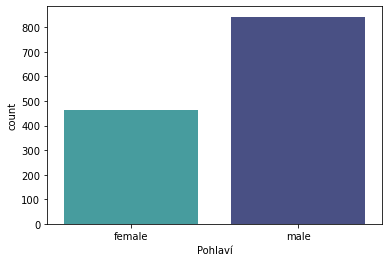

In [201]:
#cílová proměnná
sns.countplot(x='sex',data =  df, palette="mako_r")
plt.xlabel('Pohlaví')
plt.show()

In [202]:
df['sex'].value_counts()

male      843
female    464
Name: sex, dtype: int64

Cílová proměnná je nevybalancovaná -> před modelováním SMOTE

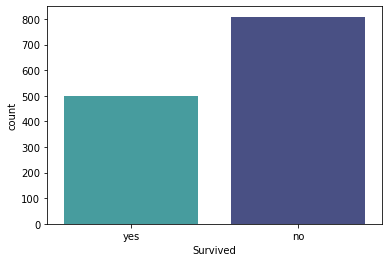

In [203]:
sns.countplot(x='survived',data =  df, palette="mako_r")
plt.xlabel('Survived')
plt.show()

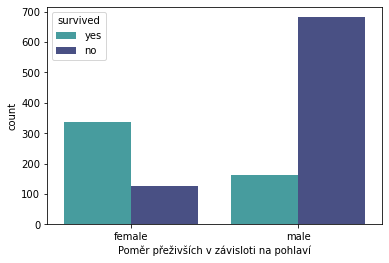

In [204]:
sns.countplot(x='sex', hue='survived',data =  df, palette="mako_r")
plt.xlabel('Poměr přeživších v závisloti na pohlaví')
plt.show()

In [205]:
df.value_counts(['sex','survived'])

sex     survived
male    no          682
female  yes         337
male    yes         161
female  no          127
dtype: int64

Velká zavislost proměnných sex a survived, většina žen přežila, zatímco u mužů tomu bylo právě naopak

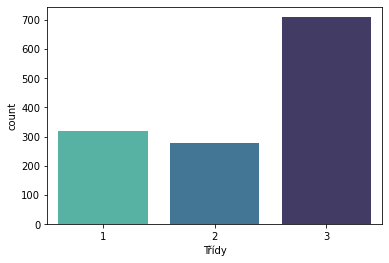

In [206]:
sns.countplot(x='pclass',data =  df, palette="mako_r")
plt.xlabel('Třídy')
plt.show()

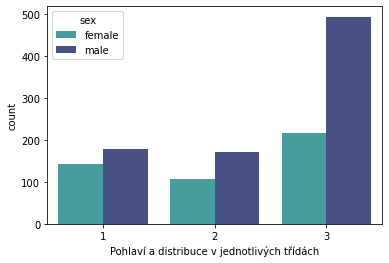

In [207]:
sns.countplot(x='pclass' ,data =  df,hue='sex', palette="mako_r")
plt.xlabel('Pohlaví a distribuce v jednotlivých třídách')
plt.show()

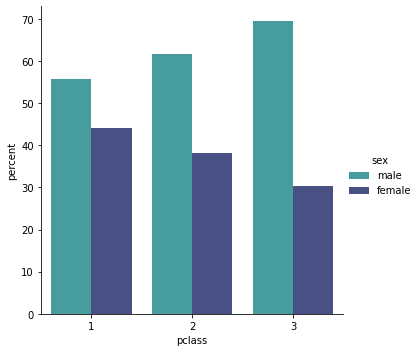

In [208]:
x,y = 'pclass', 'sex'

(df
.groupby(x)[y]
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.catplot,'data'), x=x,y='percent',hue=y,kind='bar',palette="mako_r"))

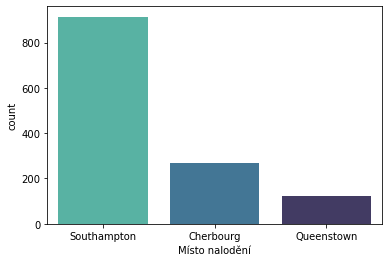

In [209]:
sns.countplot(x='embarked',data =  df, palette="mako_r")
plt.xlabel('Místo nalodění')
plt.show()

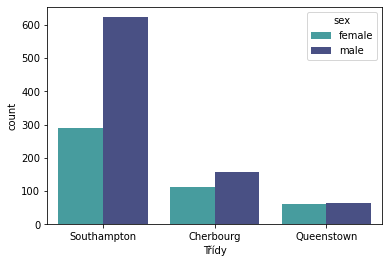

In [210]:
sns.countplot(x='embarked',data =  df,hue='sex', palette="mako_r")
plt.xlabel('Třídy')
plt.show()

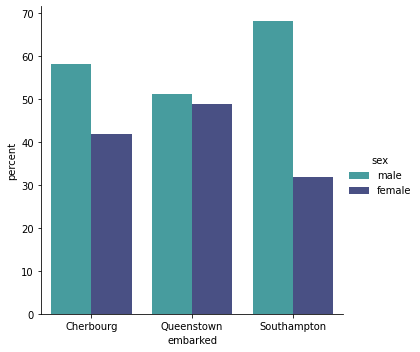

In [211]:
x,y = 'embarked', 'sex'

(df
.groupby(x)[y]
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.catplot,'data'), x=x,y='percent',hue=y,kind='bar',palette="mako_r"))

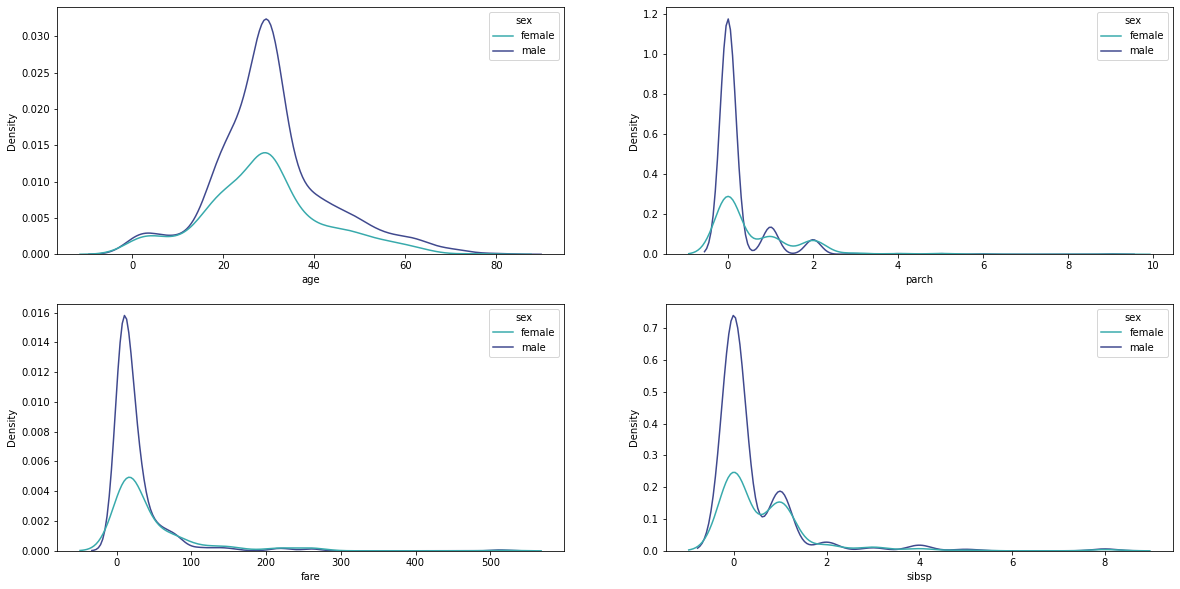

In [212]:
fig,axes=plt.subplots(2,2,figsize=(20,10))

sns.kdeplot( x=df['age'], hue=df['sex'],ax=axes[0,0],palette="mako_r")

sns.kdeplot(x=df['fare'], hue=df['sex'],ax=axes[1,0],palette="mako_r")

sns.kdeplot(x=df['parch'], hue=df['sex'], ax=axes[0,1],palette="mako_r")

sns.kdeplot(x=df['sibsp'], hue=df['sex'], ax=axes[1,1],palette="mako_r")
plt.show()

Z EDA vyplývá, že největší závislot je u proměnné survived, kde přežilo více žen než mužů. Menší trend je i u proměnné pclass a embarked, u nominálních proměnných nelze vypozorovat žádné významné trendy v závisloti s cílovou proměnnou

## Feature engineering

In [213]:
def familyAb(row):
    if (row['sibsp'] + row['parch']) > 0:
        return True
    else:
        return False

In [214]:
#df['familyAboard'] = df.apply(lambda row: familyAb(row) , axis=1)

In [215]:
# df['sibsp'] = df['sibsp'].astype('bool')
# df['parch'] = df['parch'].astype('bool')
#
#
# enc = OneHotEncoder(handle_unknown='ignore')
#
# enc_df = pd.DataFrame(enc.fit_transform(df[['survived','pclass','embarked','sibsp','parch']]).toarray())
#
# enc_df.columns = enc.get_feature_names(['survived','pclass','embarked','sibsp','parch'])
#
# df = df.join(enc_df)
#
# df = df.drop(['survived','pclass','embarked','sibsp','parch'], axis = 1)
#
# df

In [216]:
enc = OneHotEncoder(handle_unknown='ignore')

enc_df = pd.DataFrame(enc.fit_transform(df[['survived','pclass','embarked']]).toarray())

enc_df.columns = enc.get_feature_names(['survived','pclass','embarked'])

df = df.join(enc_df)

df = df.drop(['survived','pclass','embarked'], axis = 1)

df

,sex,age,sibsp,parch,fare,survived_no,survived_yes,pclass_1,pclass_2,pclass_3,embarked_Cherbourg,embarked_Queenstown,embarked_Southampton
0,female,29.000000,0,0,211.3375,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
1,male,0.916700,1,2,151.5500,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
2,female,2.000000,1,2,151.5500,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,male,30.000000,1,2,151.5500,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,female,25.000000,1,2,151.5500,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,female,14.500000,1,0,14.4542,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1305,female,29.881135,1,0,14.4542,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1306,male,26.500000,0,0,7.2250,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1307,male,27.000000,0,0,7.2250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [217]:
df.isnull().sum()

sex                     0
age                     0
sibsp                   0
parch                   0
fare                    0
survived_no             2
survived_yes            2
pclass_1                2
pclass_2                2
pclass_3                2
embarked_Cherbourg      2
embarked_Queenstown     2
embarked_Southampton    2
dtype: int64

In [218]:
df = df.dropna()

## Modely bez dalších úprav proměnných a bez vybalancování cílové proměnné

In [219]:
df['sex'] = df['sex'].replace({'female' : '1', 'male' : 0})
X = df.drop(['sex'], axis = 1)
y = df['sex']
y = y.astype('int')

C:\Users\mates\AppData\Local\Temp/ipykernel_31652/3329079473.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sex'] = df['sex'].replace({'female' : '1', 'male' : 0})


In [220]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=101)

In [221]:
ros = RandomOverSampler(sampling_strategy = "not majority")

X_train, y_train = ros.fit_resample(X_train,y_train)

scaler = StandardScaler()
train_scaled = scaler.fit_transform(X_train)
test_scaled = scaler.transform(X_test)

In [222]:
DTclassifier = DecisionTreeClassifier(max_leaf_nodes=10)
DTclassifier.fit(train_scaled, y_train)

y_pred = DTclassifier.predict(test_scaled)


accuracy_score(y_test, y_pred)

0.6475095785440613

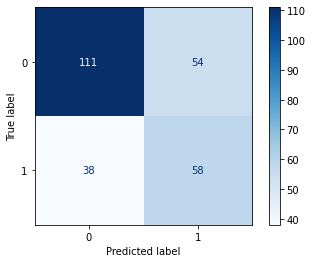

In [223]:
disp = plot_confusion_matrix(DTclassifier, test_scaled, y_test,
                                 cmap=plt.cm.Blues,)

plt.show()

[Text(209.25000000000003, 199.32, 'X[2] <= 0.029\ngini = 0.5\nsamples = 1352\nvalue = [676, 676]'),
 Text(139.5, 163.07999999999998, 'X[3] <= 0.839\ngini = 0.485\nsamples = 972\nvalue = [571, 401]'),
 Text(111.60000000000001, 126.83999999999999, 'X[1] <= -0.022\ngini = 0.471\nsamples = 896\nvalue = [556, 340]'),
 Text(55.800000000000004, 90.6, 'X[3] <= -0.513\ngini = 0.441\nsamples = 700\nvalue = [470, 230]'),
 Text(27.900000000000002, 54.359999999999985, 'gini = 0.174\nsamples = 83\nvalue = [75, 8]'),
 Text(83.7, 54.359999999999985, 'X[3] <= -0.506\ngini = 0.461\nsamples = 617\nvalue = [395, 222]'),
 Text(55.800000000000004, 18.119999999999976, 'gini = 0.484\nsamples = 105\nvalue = [43, 62]'),
 Text(111.60000000000001, 18.119999999999976, 'gini = 0.43\nsamples = 512\nvalue = [352, 160]'),
 Text(167.4, 90.6, 'X[3] <= -0.495\ngini = 0.493\nsamples = 196\nvalue = [86, 110]'),
 Text(139.5, 54.359999999999985, 'gini = 0.231\nsamples = 15\nvalue = [13, 2]'),
 Text(195.3, 54.359999999999985,

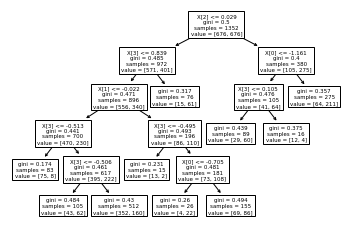

In [224]:
tree.plot_tree(DTclassifier)

In [225]:
#Gradient boosted deTrees, nejlepsi model, jen trva dlouho pri hodne datech

#vypis parametru
params = {
        'n_estimators': stats.randint(150, 1000),
        'learning_rate': stats.uniform(0.01, 0.6),
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0,2],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [6,7,8,9,10]

        }
xgb = XGBClassifier()
#vyber nejlepsich parametru
rs = RandomizedSearchCV(xgb, param_distributions=params, n_iter=5, n_jobs=4, cv=5, verbose=3, random_state=1001 )
#trenovani
rs.fit(train_scaled, y_train)

#predikce
y_pred = rs.best_estimator_.predict(test_scaled)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


C:\Users\mates\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.73598743 0.74266776 0.7137898         nan]
  warnings.warn(
C:\Users\mates\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:27:25] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [226]:
accuracy_score(y_test, y_pred)

0.6091954022988506

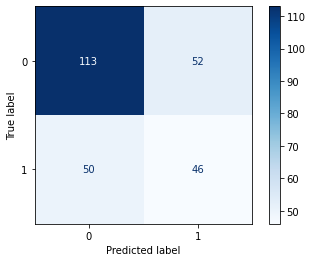

In [227]:
plot_confusion_matrix(rs.best_estimator_, test_scaled, y_test,
                                 cmap=plt.cm.Blues)

plt.show()